# Лабораторная работа №6
## Ипользование модели CART в задаче двухфакторной биометрической аутентификации
### Вариант №1
#### "Свой": Треугольное распределение
#### "Чужой": Треугольное распределение
#### Критерий информативности: Энтропия $E = -(p_1 * log(p_1) + p_2 * log(p_2))$ 

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import triang

warnings.simplefilter(action='ignore', category=FutureWarning)

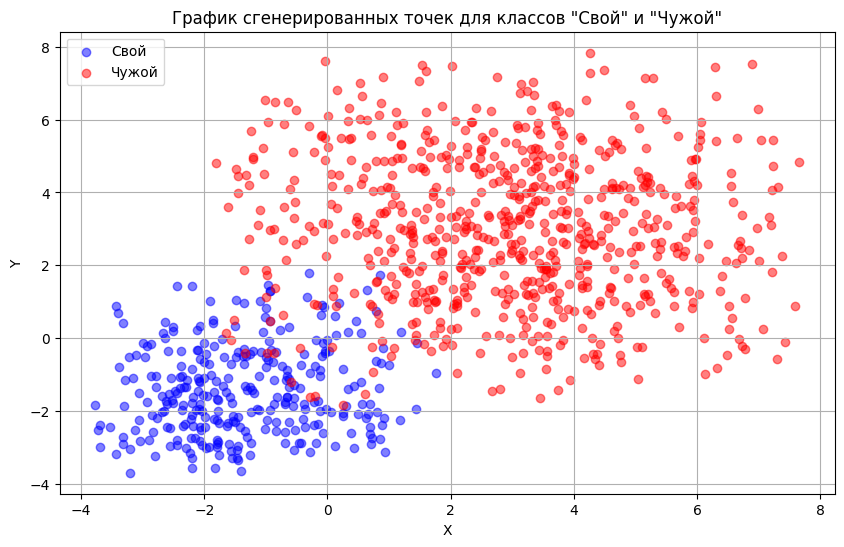

In [2]:
# Функция для генерации треугольного распределения
def generate_triangular_samples(num_samples, a, c, b):
    return triang.rvs(
        (c - a) / (b - a), 
        loc=a, 
        scale=b - a, 
        size=num_samples,
    )

# Шаг 1: Генерация данных
# Параметры для треугольного распределения (класс "Свой").
a_own, c_own, b_own = -4, -2, 2

# Параметры для треугольного распределения (класс "Чужой").
a_foreign, c_foreign, b_foreign = -2, 3, 8

# Количество выборок и размер каждой выборки
num_samples_own = 300
num_samples_foreign = 700

# Генерация выборок для классов "Свой" и "Чужой".
samples_own_x = generate_triangular_samples(
    num_samples_own, a_own, c_own, b_own,
)
samples_own_y = generate_triangular_samples(
    num_samples_own, a_own, c_own, b_own,
)
samples_foreign_x = generate_triangular_samples(
    num_samples_foreign, a_foreign, c_foreign, b_foreign,
)
samples_foreign_y = generate_triangular_samples(
    num_samples_foreign, a_foreign, c_foreign, b_foreign,
)


plt.figure(figsize=(10, 6))
plt.scatter(
    x=samples_own_x, 
    y=samples_own_y, 
    label='Свой', 
    color='blue', 
    alpha=0.5,
)
plt.scatter(
    x=samples_foreign_x, 
    y=samples_foreign_y, 
    label='Чужой', 
    color='red', 
    alpha=0.5,
)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('График сгенерированных точек для классов "Свой" и "Чужой"')
plt.grid(True)

## Установка порогов

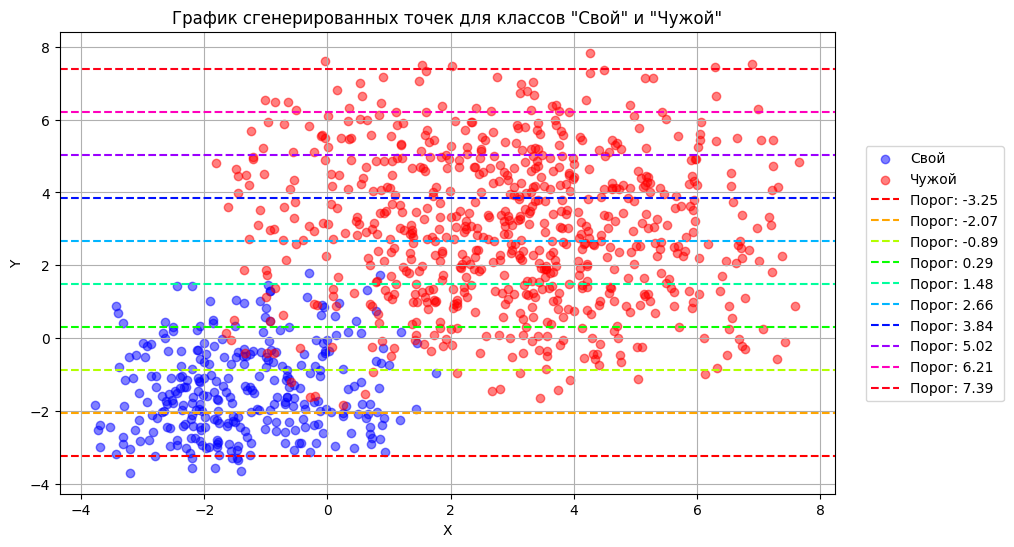

In [3]:
delta = 0.45
threshold_num = 10
thresholds = np.linspace(
    start=np.min(samples_own_y) + delta,
    stop=np.max(samples_foreign_y) - delta,
    num=threshold_num,
)

plt.figure(figsize=(10, 6))
plt.scatter(
    x=samples_own_x, 
    y=samples_own_y, 
    label='Свой', 
    color='blue', 
    alpha=0.5,
)
plt.scatter(
    x=samples_foreign_x, 
    y=samples_foreign_y, 
    label='Чужой', 
    color='red', 
    alpha=0.5,
)

threshold_colors = [
    plt.get_cmap('hsv')(i) 
    for i in np.linspace(0, 1, len(thresholds))
]
for i, threshold in enumerate(thresholds):
    plt.axhline(
        y=threshold, color=threshold_colors[i],
        linestyle='--', label=f'Порог: {threshold:.2f}',
    )

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=(1.04, 0.2))
plt.title('График сгенерированных точек для классов "Свой" и "Чужой"')
plt.grid(True)

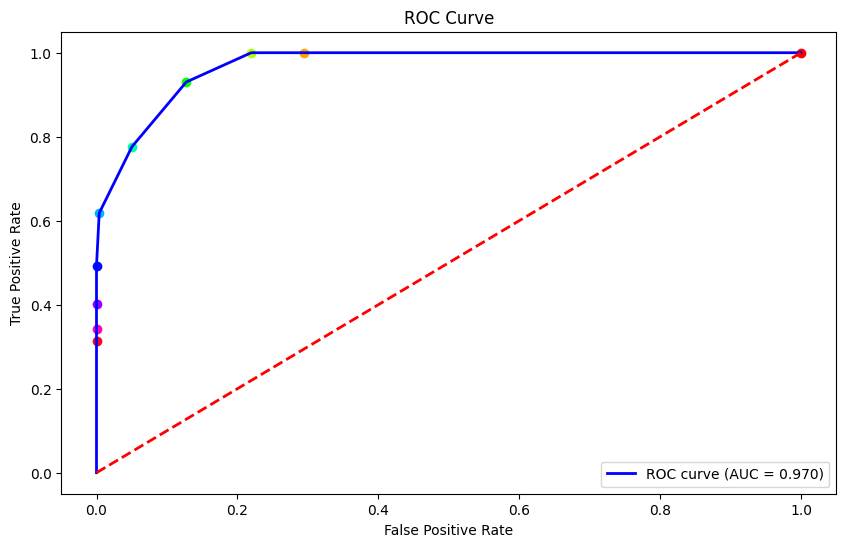

In [4]:
from sklearn.metrics import confusion_matrix, auc

# Шаг 2: Расчет компонентов матрицы ошибок
def calculate_confusion_matrix(y_true, y_pred, threshold):
    y_pred_binary = (y_pred > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    return cm.ravel()

# Создание массивов для истинных меток и предсказанных вероятностей
true_labels = np.concatenate([
    np.zeros(num_samples_own), 
     np.ones(num_samples_foreign),
])
predicted_probs = np.concatenate([
    samples_own_y, 
    samples_foreign_y,
])

# Шаг 3: Расчет компонентов матриц ошибок для различных порогов
components_matrix = np.array([
    calculate_confusion_matrix(
        true_labels, 
        predicted_probs, 
        threshold,
    )
    for threshold in thresholds
])

# Распаковка компонентов матрицы ошибок.
TP, FP, FN, TN = components_matrix.T

# Шаг 4: Построение ROC-кривой и расчет AUC
fpr = FP / (FP + TN)
tpr = TP / (TP + FN)

fpr = np.concatenate([[1], fpr, [0]])
tpr = np.concatenate([[1], tpr, [0]])

# Построение ROC-кривой
plt.figure(figsize=(10, 6))

for i, _ in enumerate(thresholds):
    plt.plot(
        [fpr[i]], [tpr[i]], 'o',
        color=threshold_colors[i],
    )
plt.plot(
    fpr, tpr, 
    color='blue', 
    lw=2, 
    label=f'ROC curve (AUC = {auc(fpr, tpr):.3f})',
)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
def rotate_points(x: np.ndarray, y: np.ndarray, angle: float) -> tuple[np.ndarray, np.ndarray]:
    angle_rad = np.radians(angle)
    x_rotated = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rotated = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return x_rotated, y_rotated


In [20]:
# Углы поворота в градусах
angle1 = 22.3
angle2 = 76.4

# Поворот первой выборки
samples_own_x_rotated1, samples_own_y_rotated1 = rotate_points(samples_own_x, samples_own_y, angle1)

# Поворот второй выборки
samples_foreign_x_rotated1, samples_foreign_y_rotated1 = rotate_points(samples_foreign_x, samples_foreign_y, angle1)

# Повторный поворот первой выборки
samples_own_x_rotated2, samples_own_y_rotated2 = rotate_points(samples_own_x_rotated1, samples_own_y_rotated1, angle2)

# Повторный поворот второй выборки
samples_foreign_x_rotated2, samples_foreign_y_rotated2 = rotate_points(samples_foreign_x_rotated1, samples_foreign_y_rotated1, angle2)


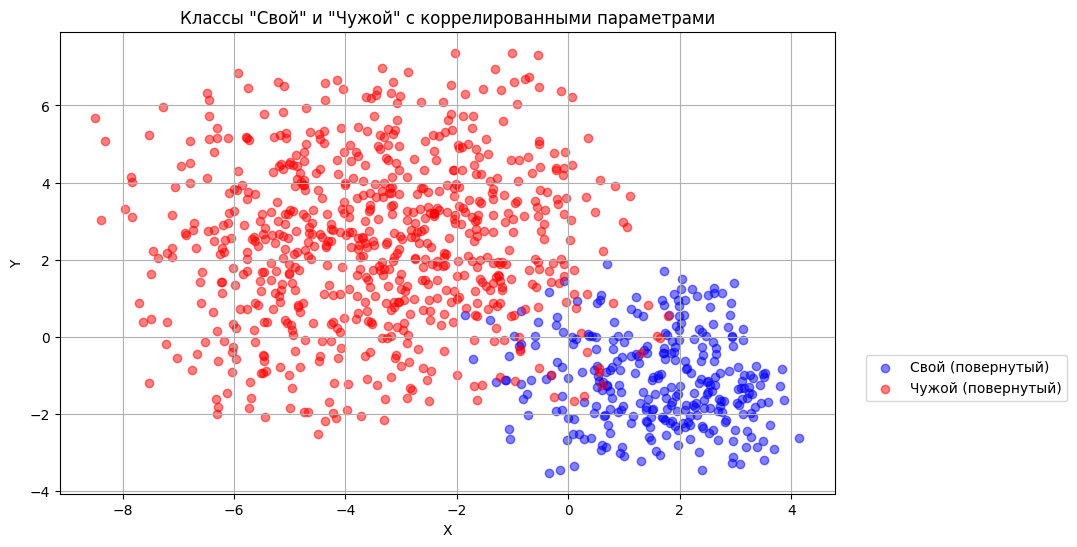

In [25]:
# График повернутых точек для классов "Свой" и "Чужой"
plt.figure(figsize=(10, 6))
plt.scatter(
    x=samples_own_x_rotated2,
    y=samples_own_y_rotated2,
    label='Свой (повернутый)', 
    color='blue', 
    alpha=0.5,
)
plt.scatter(
    x=samples_foreign_x_rotated2,
    y=samples_foreign_y_rotated2,
    label='Чужой (повернутый)', 
    color='red', 
    alpha=0.5,
)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=(1.04, 0.2))
plt.title('Классы "Свой" и "Чужой" с коррелированными параметрами')
plt.grid(True)
plt.show()

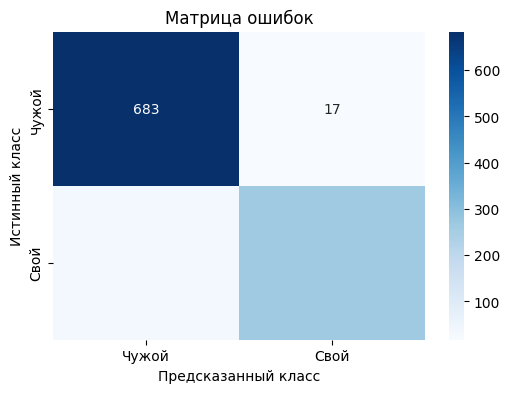

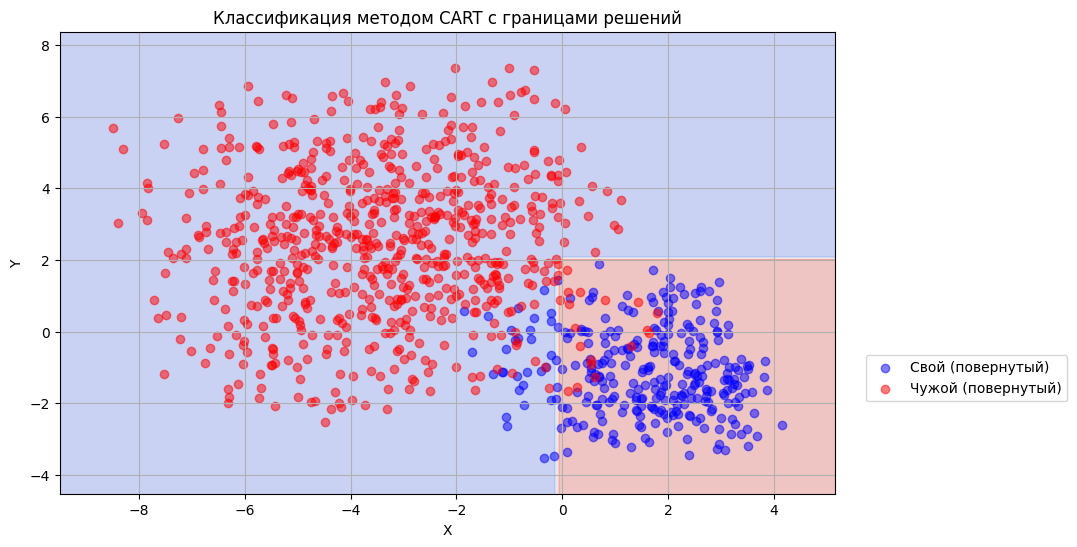

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Создание обучающей выборки и меток
X_train = np.concatenate((np.column_stack((samples_own_x_rotated2, samples_own_y_rotated2)),
                          np.column_stack((samples_foreign_x_rotated2, samples_foreign_y_rotated2))))
y_train = np.concatenate((np.ones(samples_own_x_rotated2.shape[0]), np.zeros(samples_foreign_x_rotated2.shape[0])))


# Обучение дерева решений
clf = DecisionTreeClassifier(
    max_depth=2,
    criterion='entropy'
)
model = clf.fit(X_train, y_train)

# Предсказание меток для обучающей выборки
y_pred = model.predict(X_train)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_train, y_pred)

# Построение матрицы ошибок с использованием seaborn для лучшей визуализации
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Чужой', 'Свой'], yticklabels=['Чужой', 'Свой'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Построение графика с разделением выборок прямыми
plt.figure(figsize=(10, 6))

# Разделение области на сетку
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
                     np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))

# Предсказание для каждой точки сетки
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Рисование контуров решающей области
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Рисование точек выборки
plt.scatter(samples_own_x_rotated2, samples_own_y_rotated2, label='Свой (повернутый)', color='blue', alpha=0.5)
plt.scatter(samples_foreign_x_rotated2, samples_foreign_y_rotated2, label='Чужой (повернутый)', color='red', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=(1.04, 0.2))
plt.title('Классификация методом CART с границами решений')
plt.grid(True)
plt.show()

In [42]:
conf_matrix

array([[683,  17],
       [ 35, 265]])

[Text(0.5, 0.8333333333333334, 'x[0] <= -0.035\nentropy = 0.881\nsamples = 1000\nvalue = [700, 300]'),
 Text(0.25, 0.5, 'x[0] <= -1.139\nentropy = 0.285\nsamples = 705\nvalue = [670, 35]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.057\nsamples = 605\nvalue = [601, 4]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.893\nsamples = 100\nvalue = [69, 31]'),
 Text(0.75, 0.5, 'x[1] <= 2.054\nentropy = 0.474\nsamples = 295\nvalue = [30, 265]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.329\nsamples = 282\nvalue = [17, 265]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 13\nvalue = [13, 0]')]

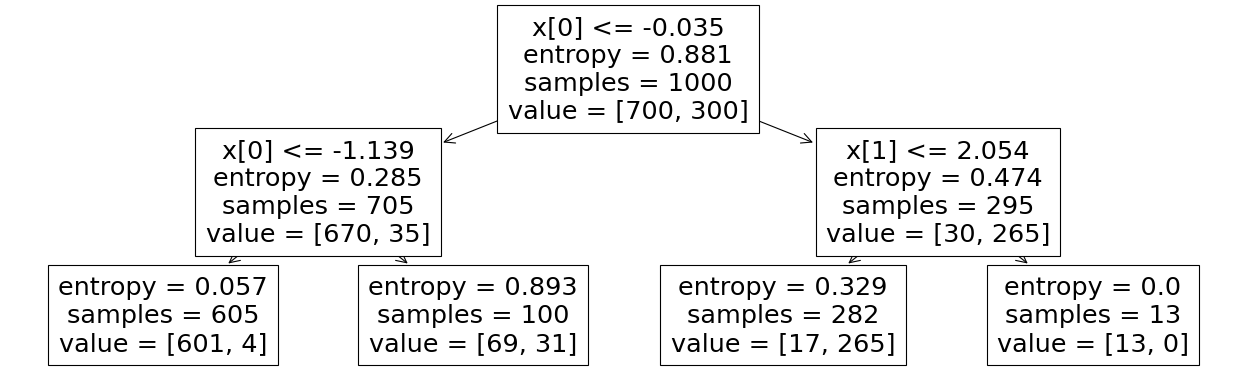

In [43]:
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn.tree import plot_tree
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plot_tree(model)